# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [6]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence #, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [7]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [8]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [9]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [10]:
DATA_STORE = '../data/assets.h5'

In [11]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [12]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [13]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [14]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [15]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [16]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [17]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [18]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [19]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [20]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [21]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [22]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [23]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [24]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [25]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [26]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [27]:
algo = 'dummy_clf'

In [28]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    6.4s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.5s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [29]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.814285,-17.855239
Precision,0.548116,0.504698
Recall,0.505758,0.504622


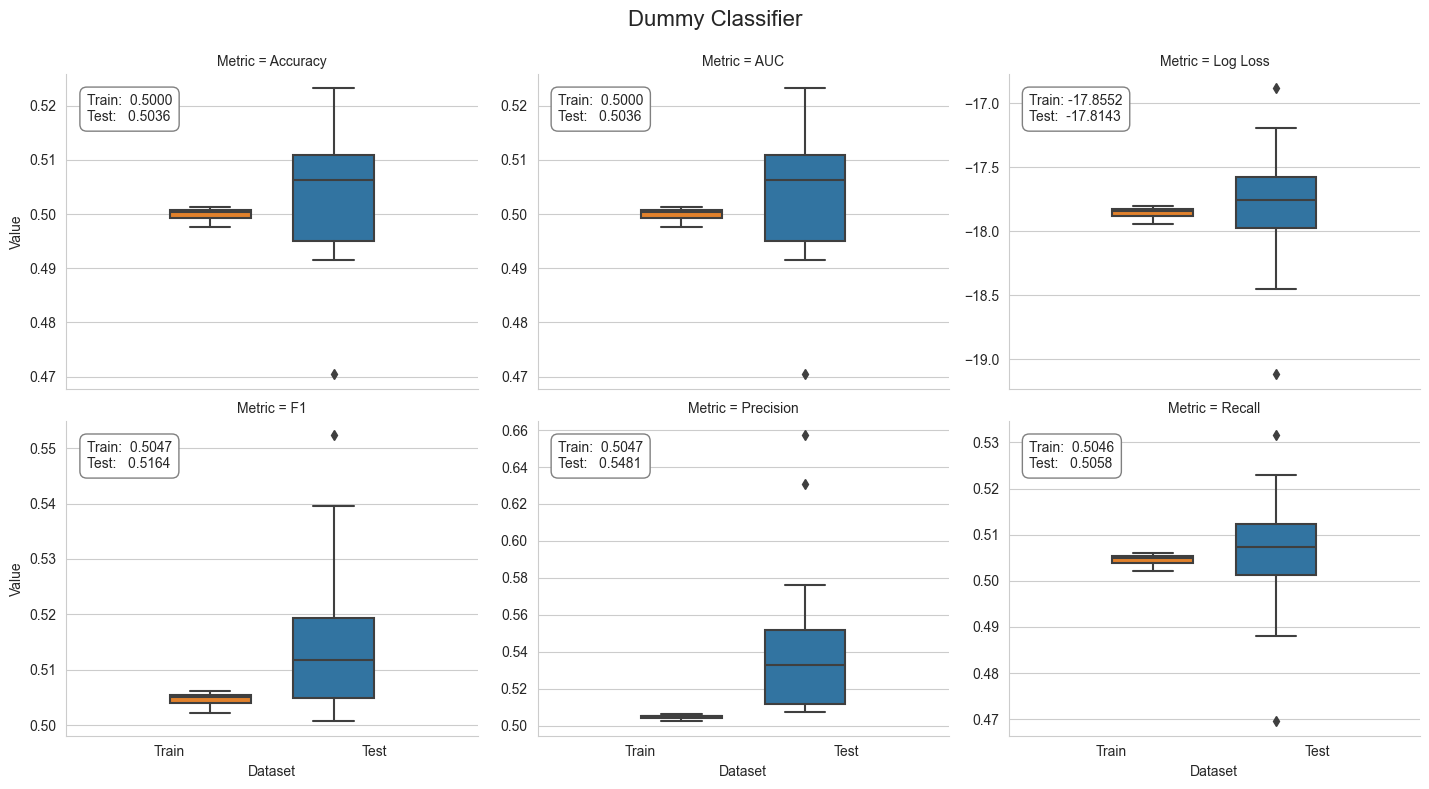

In [30]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [32]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                # min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [33]:
algo = 'random_forest'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  6.4min remaining: 32.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.0min finished


### Plot Results

In [35]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.527919,1.000000
Accuracy,0.514818,0.999999
F1,0.508370,0.999999
Log Loss,-0.691832,-0.169289
Precision,0.563167,0.999999
Recall,0.542256,0.999999


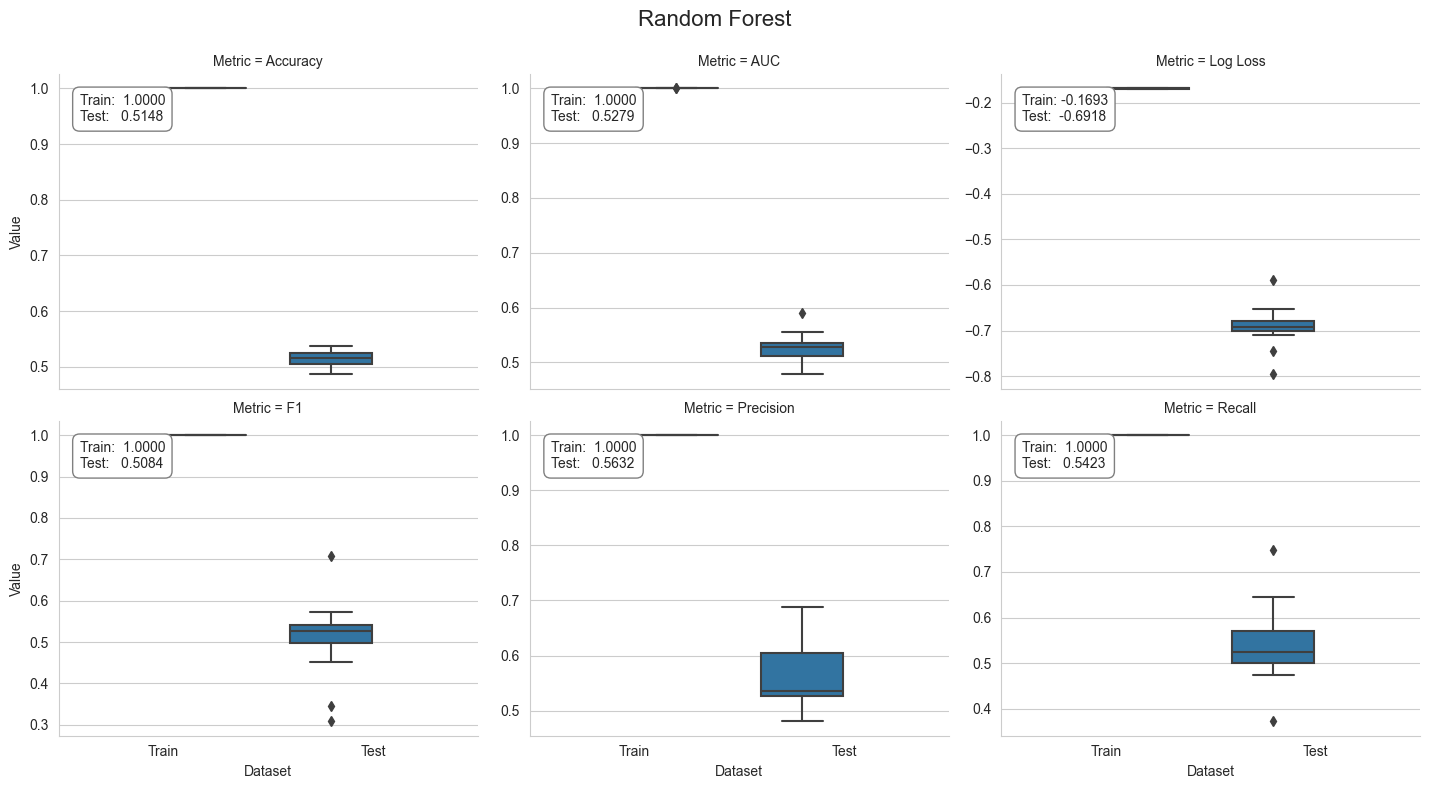

In [36]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [37]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        # min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [38]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [39]:
algo = 'adaboost'

In [40]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  5.3min remaining: 26.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.6min finished


### Plot Result

In [41]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536688,0.608124
Accuracy,0.504776,0.569173
F1,0.461823,0.570940
Log Loss,-0.692848,-0.692697
Precision,0.512652,0.583552
Recall,0.571590,0.588136


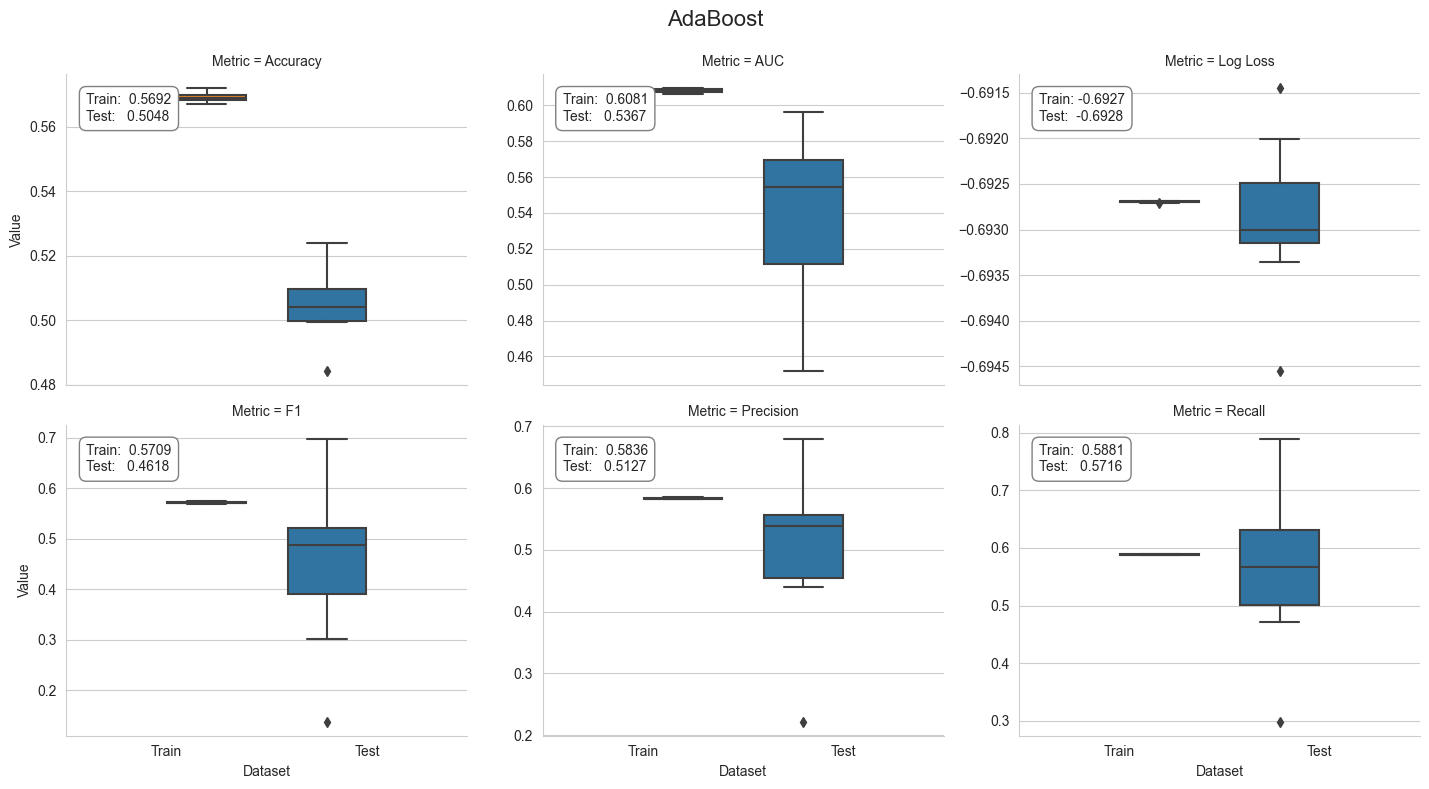

In [42]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [43]:
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [44]:
algo = 'sklearn_gbm'

In [45]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   35.8s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   37.4s finished


### Plot Results

In [46]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.544156,0.749085
Accuracy,0.512575,0.675354
F1,0.478534,0.681539
Log Loss,-0.695436,-0.595745
Precision,0.568434,0.692897
Recall,0.564880,0.689413


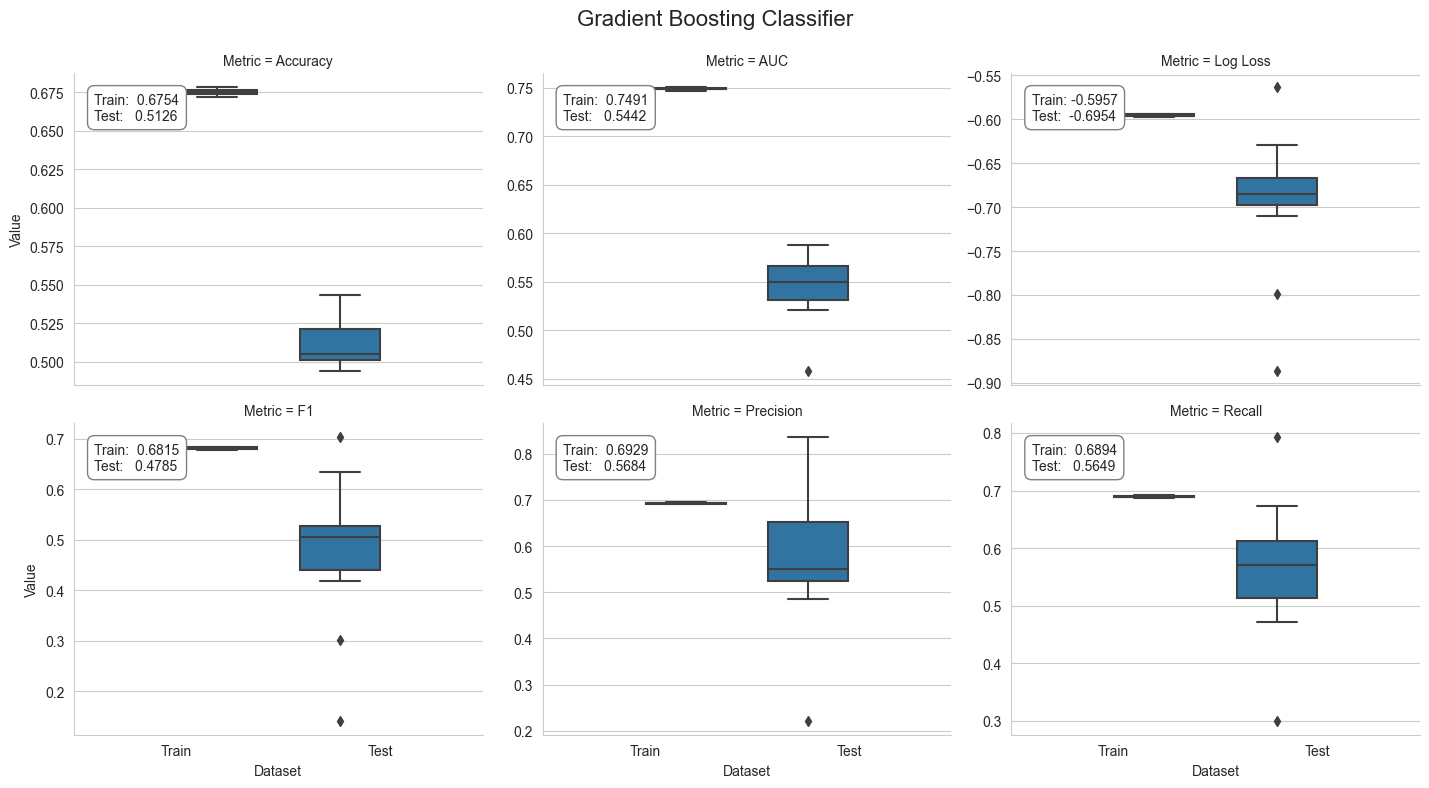

In [47]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [48]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [49]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [50]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5787351831732119

In [51]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.59922945025616

#### One-way and two-way partial depende plots

NameError: name 'plot_partial_dependence' is not defined

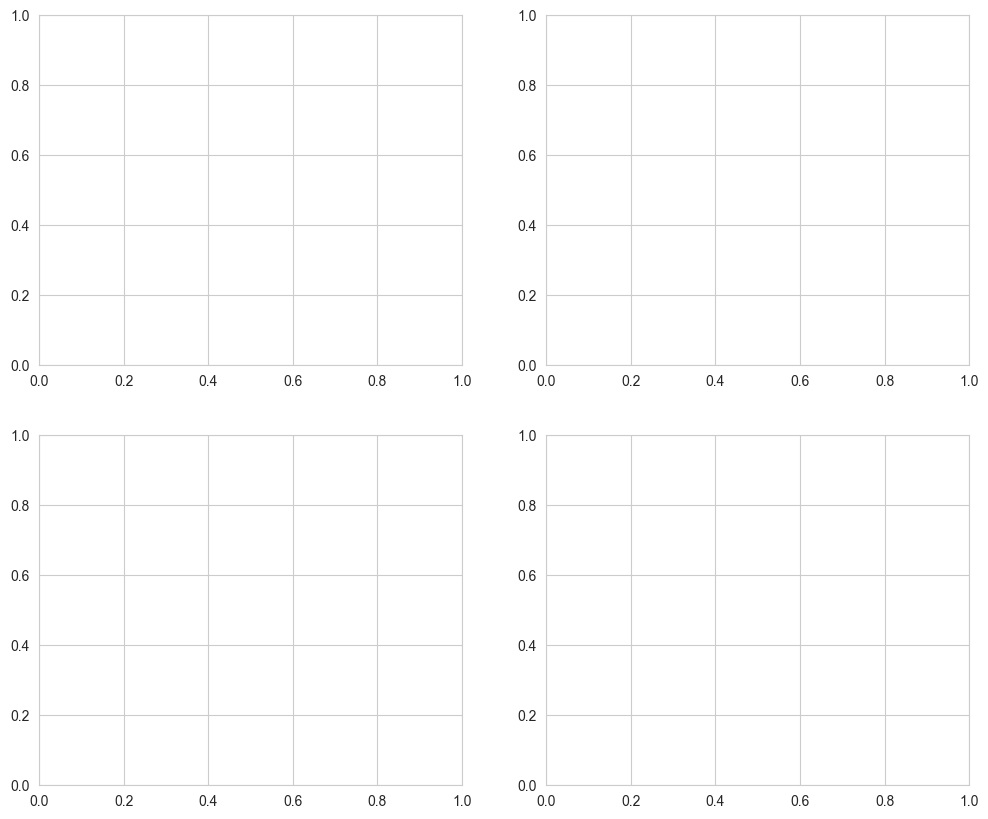

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)


#### Two-way partial dependence as 3D plot

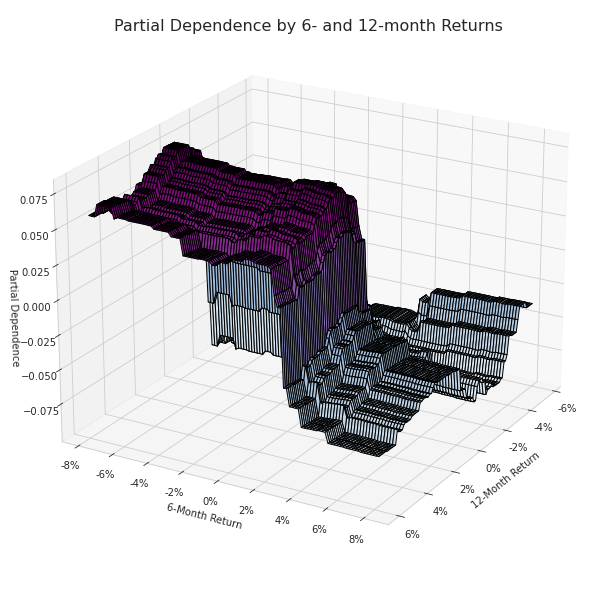

In [ ]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()


## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [ ]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [ ]:
algo = 'xgboost'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  7.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.0min finished


### Plot Results

In [ ]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.523803,0.684837
Accuracy,0.501167,0.618149
F1,0.391726,0.621304
Log Loss,-0.705113,-0.643818
Precision,0.531815,0.640388
Recall,0.494786,0.637127


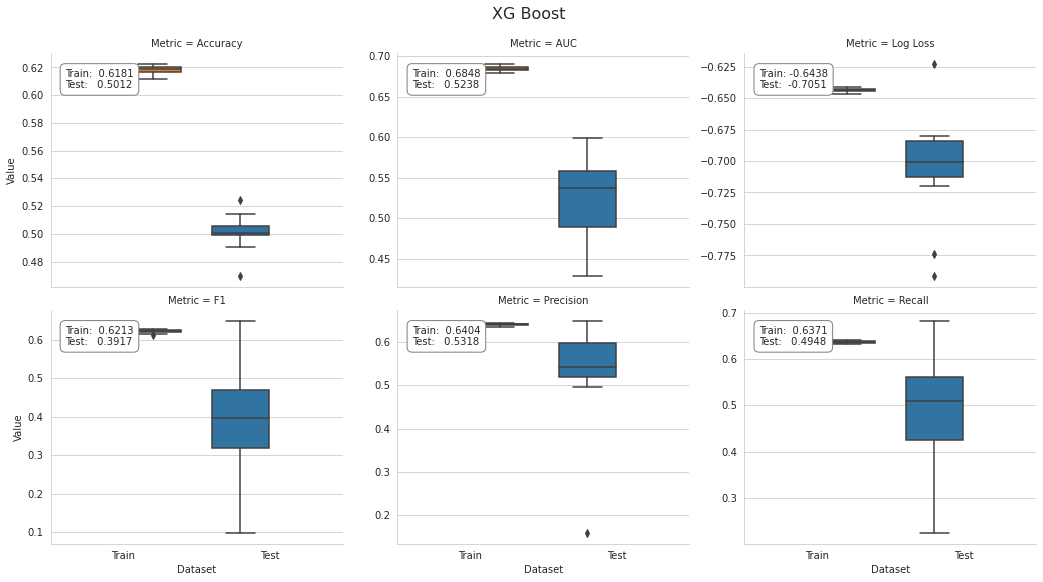

In [ ]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [ ]:
xgb_clf.fit(X=X_dummies, y=y)

[20:19:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:19:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

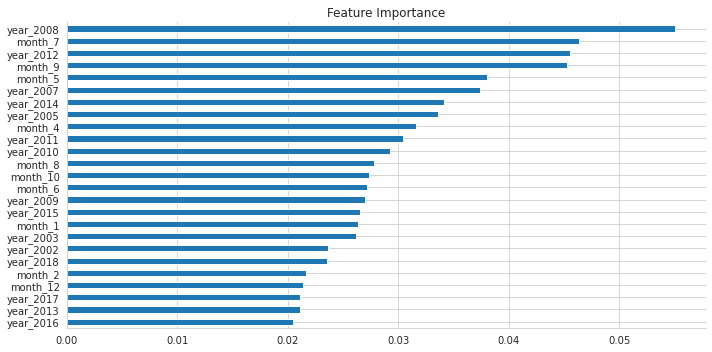

In [ ]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [ ]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [ ]:
algo = 'lgb_factors'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 30.7min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 30.8min finished


##### Plot Results

In [ ]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.534674,0.750110
Accuracy,0.513278,0.676953
F1,0.434291,0.683308
Log Loss,-0.722875,-0.592547
Precision,0.559479,0.691272
Recall,0.504942,0.689605


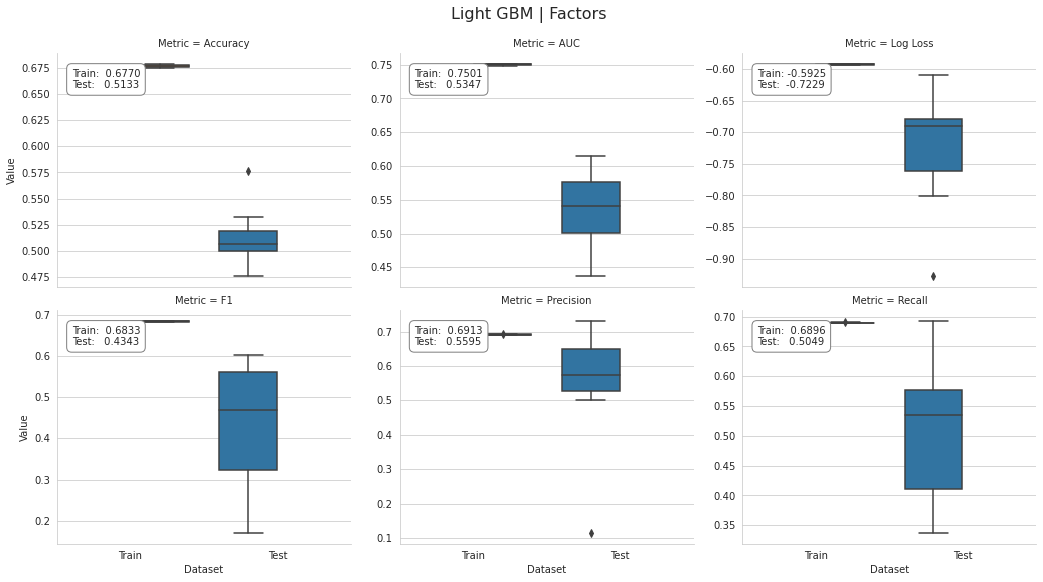

In [ ]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [ ]:
algo = 'lgb_dummies'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 10.2min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.2min finished


##### Plot results

In [ ]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.525324,0.743517
Accuracy,0.512141,0.670014
F1,0.434198,0.676106
Log Loss,-0.704733,-0.600785
Precision,0.558771,0.688686
Recall,0.508796,0.684816


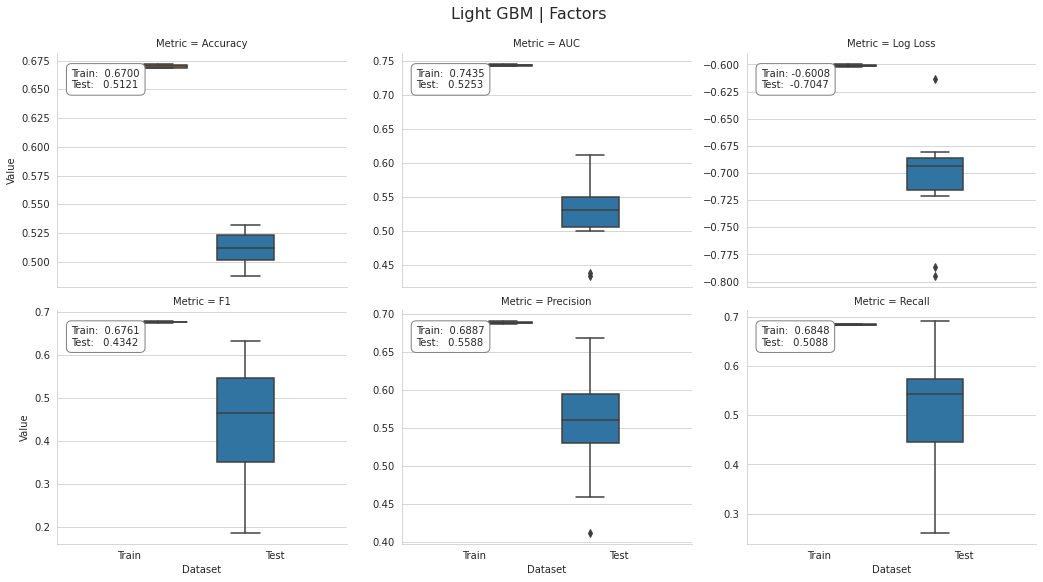

In [ ]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [ ]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [ ]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [ ]:
algo = 'catboost'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params=fit_params,
                                           n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 30.3min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 30.3min finished


#### Plot Results

In [ ]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.540770,0.802151
Accuracy,0.532725,0.720658
F1,0.537121,0.726497
Log Loss,-0.689399,-0.539176
Precision,0.582897,0.729352
Recall,0.546427,0.729151


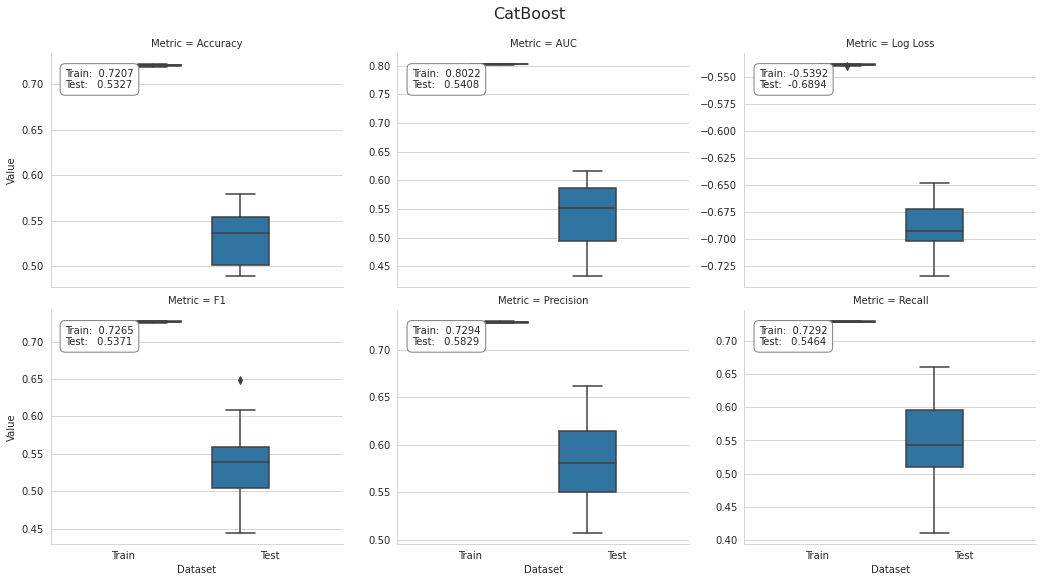

In [ ]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

> Naturally, the following requires that you have a GPU.

#### Configure

In [ ]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [ ]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [ ]:
algo = 'catboost_gpu'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               y=y,
                                               X=X_factors,
                                               fit_params=fit_params, 
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

#### Plot Results

In [ ]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.534941,0.779761
Accuracy,0.519893,0.700589
F1,0.478687,0.706628
Log Loss,-0.692898,-0.559732
Precision,0.572199,0.709989
Recall,0.528337,0.709944


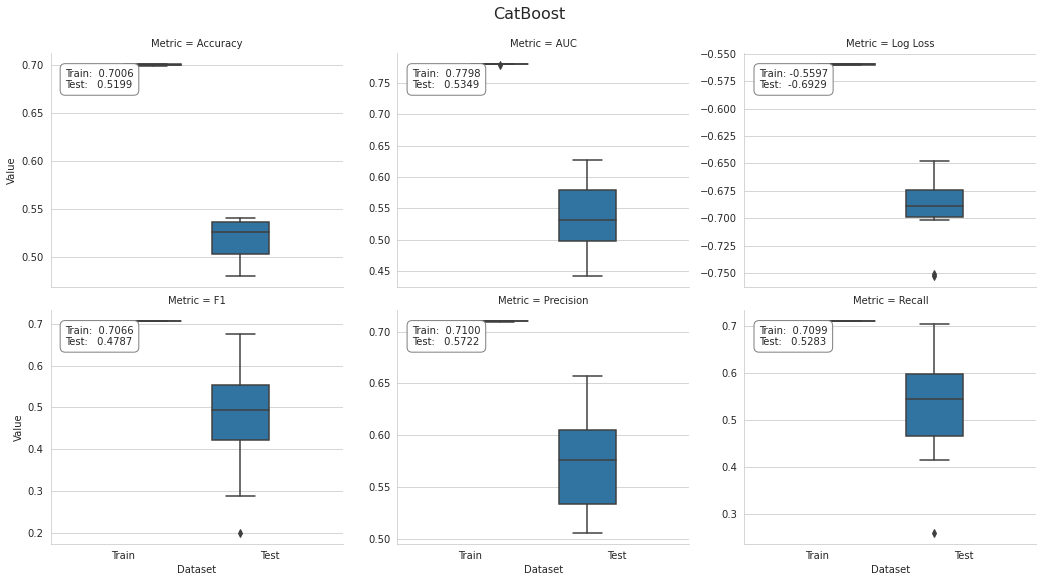

In [ ]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [ ]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost,0.540770,0.532725,0.537121,-0.689399,0.582897,0.546427
AdaBoost,0.536567,0.505709,0.464293,-0.692850,0.544433,0.571999
CatBoost GPU,0.534941,0.519893,0.478687,-0.692898,0.572199,0.528337
LightGBM Factors,0.534674,0.513278,0.434291,-0.722875,0.559479,0.504942
Gradient Booster,0.531743,0.505791,0.448612,-0.697194,0.551708,0.543934
LightGBM Dummies,0.525324,0.512141,0.434198,-0.704733,0.558771,0.508796
Random Forest,0.524482,0.512583,0.502093,-0.694309,0.557773,0.537495
XGBoost,0.523803,0.501167,0.391726,-0.705113,0.531815,0.494786
Baseline,0.503582,0.503582,0.516424,-17.070718,0.548116,0.505758


In [ ]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [ ]:
print(run_time)

{'dummy_clf': 3.446434736251831, 'random_forest': 486.9282796382904, 'adaboost': 385.62260723114014, 'sklearn_gbm': 53.61000990867615, 'xgboost': 477.78596901893616, 'lgb_factors': 1847.2539386749268, 'lgb_dummies': 613.5608298778534, 'catboost': 1819.1900961399078}


In [ ]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [ ]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [ ]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
# auc = auc[auc.Model != 'Baseline']

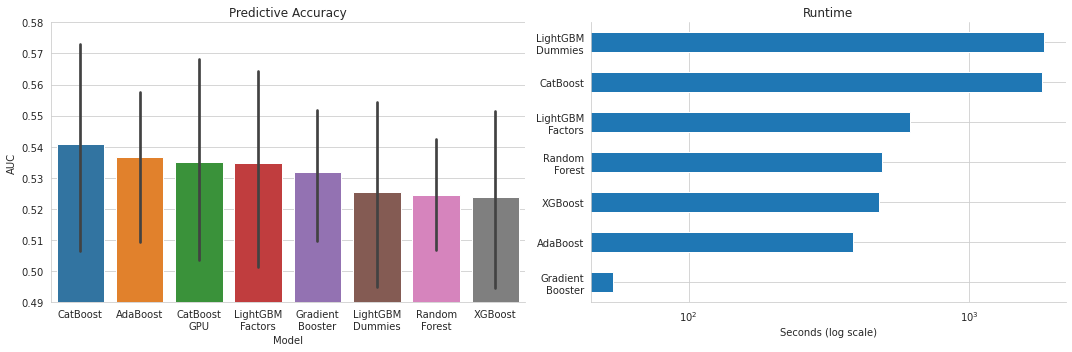

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()